In [ ]:
from google.colab import drive
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D,BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.cluster import KMeans

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Check if the directory is empty. If it isn't list the contents so the user can diagnose.
if os.path.exists('/content/drive') and os.listdir('/content/drive'):
  print("The /content/drive directory is not empty and contains the following files:")
  for item in os.listdir('/content/drive'):
    print(item)
else:
  # If the directory is empty or doesn't exist, proceed with mounting.
  drive.mount('/content/drive')

The /content/drive directory is not empty and contains the following files:
MyDrive
.shortcut-targets-by-id
.file-revisions-by-id
.Trash-0
.Encrypted


In [ ]:
!cp "/content/drive/MyDrive/Fingernails (1).zip" "/content/"

In [ ]:
!unzip "/content/drive/MyDrive/Fingernails (1).zip"

Archive:  /content/drive/MyDrive/Fingernails (1).zip
   creating: Fingernails/
   creating: Fingernails/Fingernails/
  inflating: Fingernails/Fingernails/Anemic-Fin-007 (10).png  
  inflating: Fingernails/Fingernails/Anemic-Fin-007 (11).png  
  inflating: Fingernails/Fingernails/Anemic-Fin-007 (12).png  
  inflating: Fingernails/Fingernails/Anemic-Fin-007 (2).png  
  inflating: Fingernails/Fingernails/Anemic-Fin-007 (3).png  
  inflating: Fingernails/Fingernails/Anemic-Fin-007 (4).png  
  inflating: Fingernails/Fingernails/Anemic-Fin-007 (5).png  
  inflating: Fingernails/Fingernails/Anemic-Fin-007 (6).png  
  inflating: Fingernails/Fingernails/Anemic-Fin-007 (7).png  
  inflating: Fingernails/Fingernails/Anemic-Fin-007 (8).png  
  inflating: Fingernails/Fingernails/Anemic-Fin-007 (9).png  
  inflating: Fingernails/Fingernails/Anemic-Fin-007.png  
  inflating: Fingernails/Fingernails/Anemic-Fin-008 (10).png  
  inflating: Fingernails/Fingernails/Anemic-Fin-008 (11).png  
  inflating: F


Loaded 4260 images with labels:
Anemic (1): 2521
Non-anemic (0): 1695


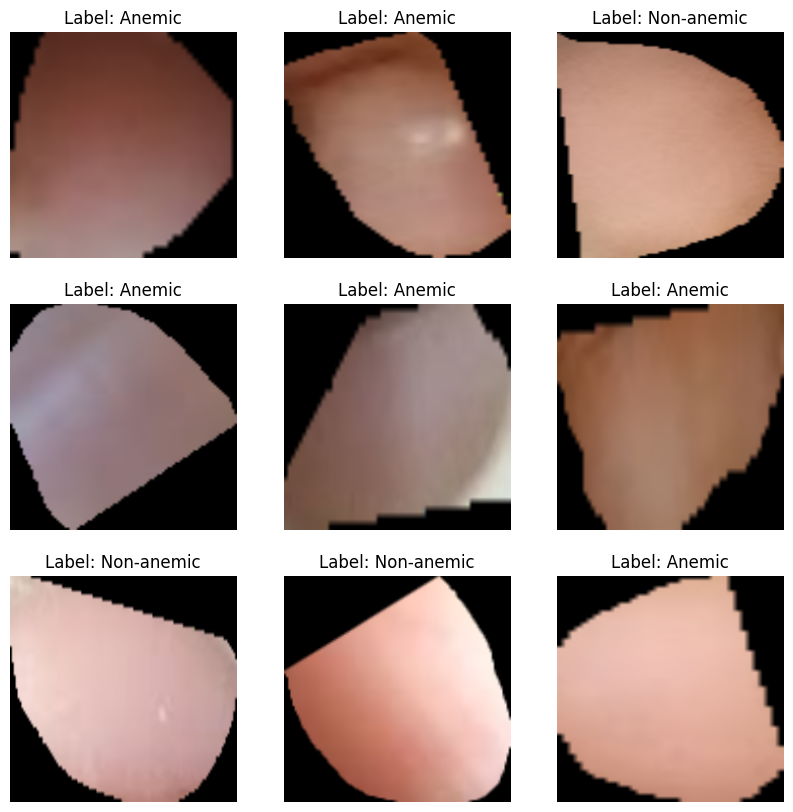

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

def load_and_preprocess_images(folder_path, target_size=(224, 224)):
    images = []
    labels = []

    for filename in os.listdir(folder_path):
        if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
            # Load image
            img = cv2.imread(os.path.join(folder_path, filename))
            if img is not None:
                # Resize and normalize
                img = cv2.resize(img, target_size)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = img.astype('float32') / 255.0
                images.append(img)

                # Assign labels based on filename
                if 'anemic' in filename.lower() and 'non' not in filename.lower():
                    labels.append(1)  # Anemic
                elif 'non' in filename.lower():
                    labels.append(0)  # Non-anemic
                else:
                    labels.append(-1)  # Unknown label

    return np.array(images), np.array(labels)

# Load the dataset
dataset_folder = '/content/Fingernails/Fingernails'  # Path to your dataset folder
X, y = load_and_preprocess_images(dataset_folder)

# Split dataset into train and validation sets
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Display dataset info
print(f"\nLoaded {len(X)} images with labels:")
print(f"Anemic (1): {sum(y == 1)}")
print(f"Non-anemic (0): {sum(y == 0)}")

# Visualize a few examples
plt.figure(figsize=(10, 10))
for i in range(9):  # Display 9 images from the training set
    plt.subplot(3, 3, i+1)
    plt.imshow(X_train[i])
    plt.title(f"Label: {'Anemic' if y_train[i] == 1 else 'Non-anemic'}")
    plt.axis('off')
plt.show()


In [ ]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def build_autoencoder(input_shape=(224, 224, 3)):
    # Encoder
    input_img = Input(shape=input_shape)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)

    # Decoder
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    # Full autoencoder
    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

    # Encoder for feature extraction
    encoder = Model(input_img, encoded)

    return autoencoder, encoder

autoencoder, encoder = build_autoencoder()
autoencoder.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 56, 56, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 128)    │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 112, 112, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 112, 112, 64)   │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 224, 224, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 224, 224, 3)    │         1,731 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,331,459 (5.08 MB)

 Trainable params: 1,331,459 (5.08 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
213/213 ━━━━━━━━━━━━━━━━━━━━ 43s 138ms/step - loss: 0.0260 - val_loss: 0.0011
Epoch 2/15
213/213 ━━━━━━━━━━━━━━━━━━━━ 24s 110ms/step - loss: 0.0011 - val_loss: 7.2809e-04
Epoch 3/15
213/213 ━━━━━━━━━━━━━━━━━━━━ 24s 111ms/step - loss: 7.0519e-04 - val_loss: 5.5662e-04
Epoch 4/15
213/213 ━━━━━━━━━━━━━━━━━━━━ 24s 114ms/step - loss: 5.7429e-04 - val_loss: 4.0217e-04
Epoch 5/15
213/213 ━━━━━━━━━━━━━━━━━━━━ 25s 115ms/step - loss: 4.0081e-04 - val_loss: 6.1187e-04
Epoch 6/15
213/213 ━━━━━━━━━━━━━━━━━━━━ 24s 114ms/step - loss: 3.5418e-04 - val_loss: 2.7938e-04
Epoch 7/15
213/213 ━━━━━━━━━━━━━━━━━━━━ 24s 114ms/step - loss: 3.2738e-04 - val_loss: 3.3109e-04
Epoch 8/15
213/213 ━━━━━━━━━━━━━━━━━━━━ 24s 114ms/step - loss: 4.7594e-04 - val_loss: 2.3128e-04
Epoch 9/15
213/213 ━━━━━━━━━━━━━━━━━━━━ 24s 114ms/step - loss: 2.2980e-04 - val_loss: 2.0060e-04
Epoch 10/15
213/213 ━━━━━━━━━━━━━━━━━━━━ 24s 114ms/step - loss: 2.0792e-04 - val_loss: 5.7705e-04
Epoch 11/15
213/213 ━━━━━━━━━━━━━━━━━━━━ 

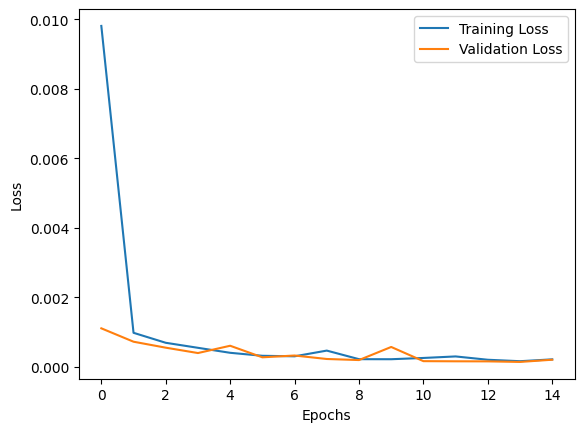

In [ ]:
# Train the autoencoder
history = autoencoder.fit(
    X_train, X_train,
    epochs=15,
    batch_size=16,
    shuffle=True,
    validation_data=(X_val, X_val)
)

# Plot training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
def extract_features(encoder, images):
    features = encoder.predict(images)
    # Flatten the features to 1D vector per image
    features_flat = features.reshape((features.shape[0], -1))
    return features_flat

# Extract features for images
train_features = extract_features(encoder, X_train)
val_features = extract_features(encoder, X_val)

# Saving extracted features to files
features_dir = '/content/children_finger_features'
os.makedirs(features_dir, exist_ok=True)

# Save features
np.save(os.path.join(features_dir, 'train_features.npy'), train_features)
np.save(os.path.join(features_dir, 'train_labels.npy'), y_train)
np.save(os.path.join(features_dir, 'val_features.npy'), val_features)
np.save(os.path.join(features_dir, 'val_labels.npy'), y_val)

print("Feature extraction complete! Files saved in /content/children_finger_features")


107/107 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step
Feature extraction complete! Files saved in /content/children_finger_features


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


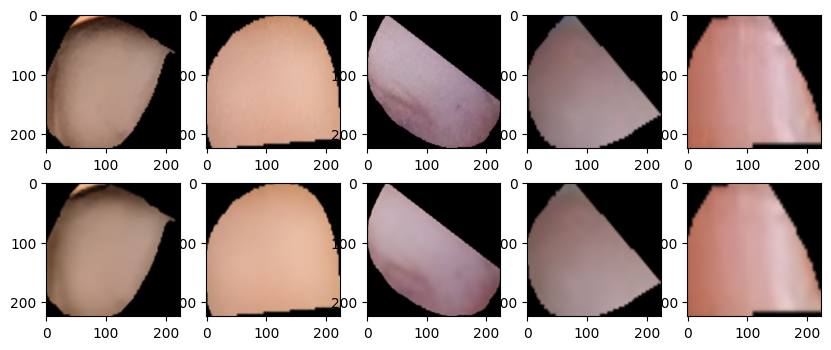

In [ ]:
# Visualize some reconstructions
decoded_imgs = autoencoder.predict(X_val[:5])

plt.figure(figsize=(10,4))
for i in range(5):
    # Original
    plt.subplot(2,5,i+1)
    plt.imshow(X_val[i])
    # Reconstruction
    plt.subplot(2,5,i+6)
    plt.imshow(decoded_imgs[i])
plt.show()
